In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats.stats import pearsonr
from sklearn import datasets, linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.compat import lzip

sns.set(context="notebook", palette="Spectral", style="darkgrid", font_scale=1.5, color_codes=True)


# Linear Regression Diagnostics

In [2]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)  # Load diabetes dataset


In [3]:
X.drop(["sex"], axis=1, inplace=True)  # Drop sex attribute


In [4]:
df = pd.concat([X, y], axis=1)  # Concatenate X and y
df.head()


,age,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


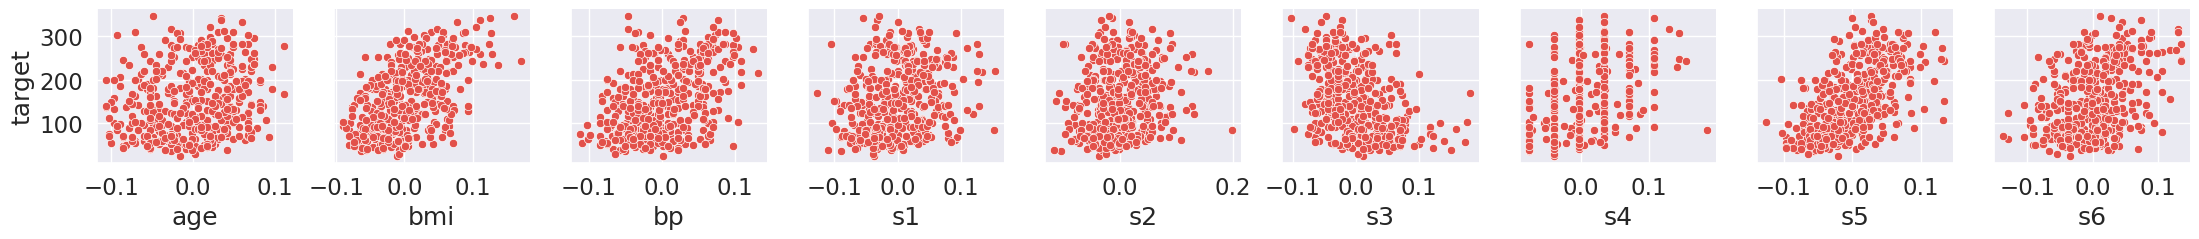

In [5]:
p = sns.pairplot(df, x_vars=X.columns.tolist(), y_vars=["target"])


In [6]:
model_fit = sm.OLS(y, sm.add_constant(X)).fit()  # Fit model
y_pred = model_fit.fittedvalues  # Get Predictions
residuals = model_fit.resid  # Get Residuals
std_residuals = model_fit.get_influence().resid_studentized_internal #Standardized residuals


In [7]:
print("R squared: {}".format(r2_score(y_true=y, y_pred=y_pred)))


R squared: 0.5005804863066201


In [8]:
# Checking normality of error
mean_residuals = np.mean(std_residuals)
mean_residuals


0.0003287267922073479

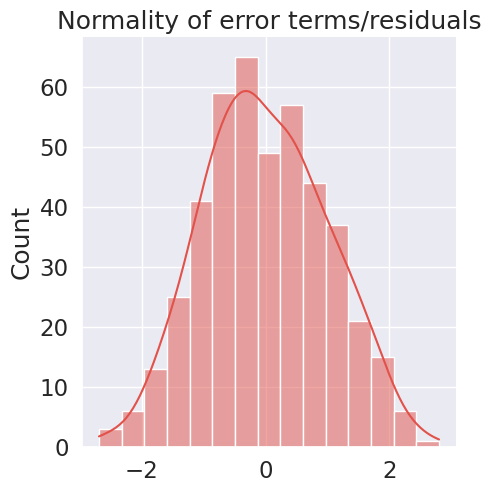

In [9]:
p = sns.displot(std_residuals, kde=True)
p = plt.title("Normality of error terms/residuals")


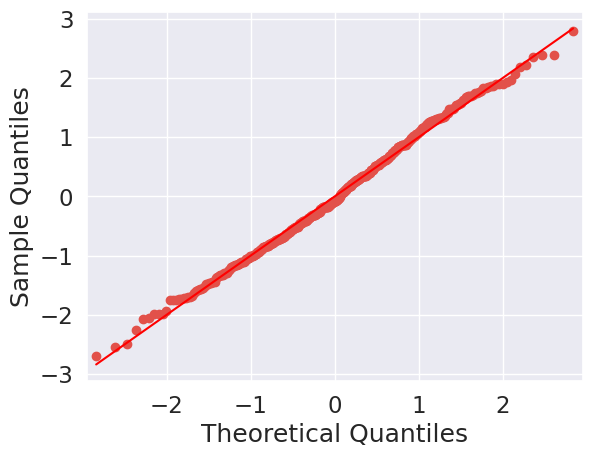

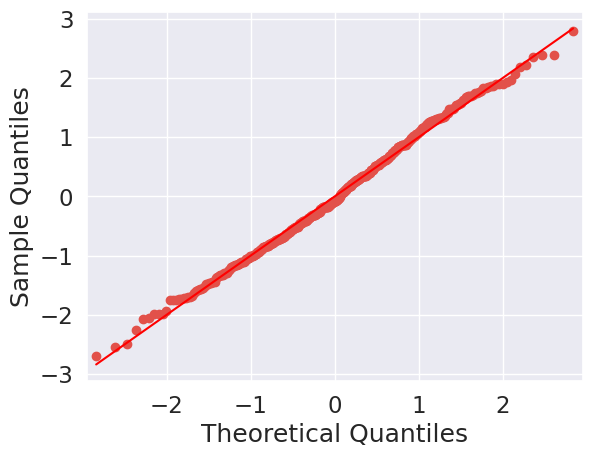

In [10]:
# QQ plot
sm.qqplot(std_residuals, line="s")


Text(0, 0.5, 'Residuals')

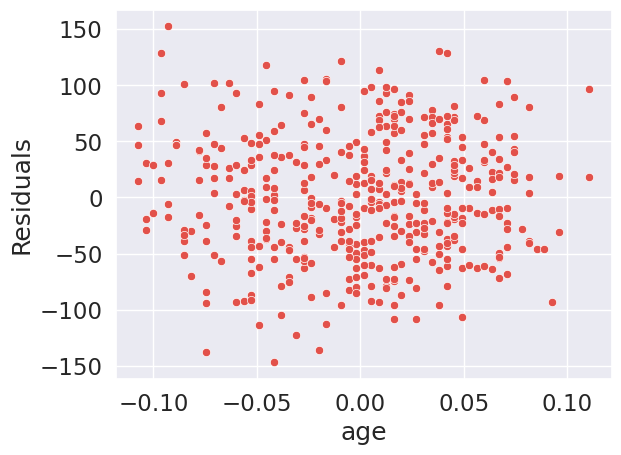

In [11]:
# Residual Plots
p = sns.scatterplot(x=X["age"], y=residuals)
plt.ylabel("Residuals")


Text(0, 0.5, 'Standardized Residuals')

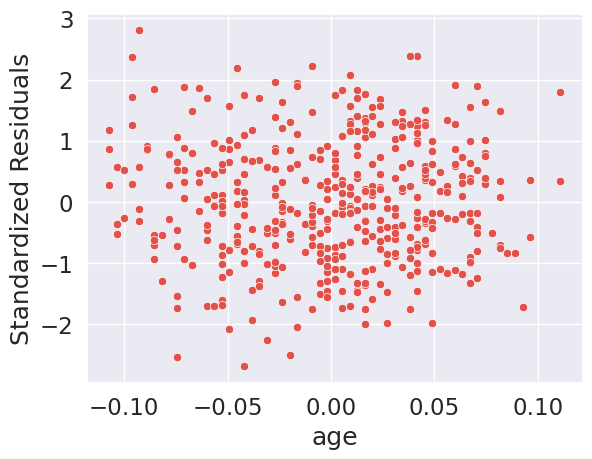

In [14]:
# Homoscedasticity (Constant variance of errors)
p = sns.scatterplot(x=X["age"], y=std_residuals)
plt.xlabel("age")
plt.ylabel("Standardized Residuals")


In [15]:
# Null hypothesis errors are homoscedastic
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(std_residuals, X)
lzip(name, test)


[('F statistic', 0.9422187774031964), ('p-value', 0.6674030529380176)]

In [16]:
# Checking for correlation of residuals with features
for column in X.columns:
    corr_test = pearsonr(X[column], std_residuals)
    print(column, corr_test[0])


age 7.507853128080333e-05
bmi 0.00017511903453395344
bp 8.920148674720907e-05
s1 -0.0005154335036842133
s2 -6.609946244478734e-05
s3 0.00015345718837022487
s4 -0.0004127839677016028
s5 -0.0007803785286405749
s6 -0.00013792884749040668


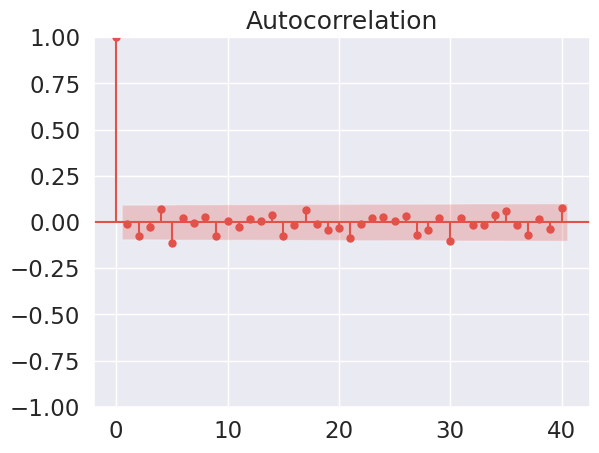

In [17]:
# Autocorrelation
sm.graphics.tsa.plot_acf(std_residuals, lags=40)
plt.show()


# PCR and PLS

In [18]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)  # Load diabetes dataset


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


In [20]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # Keep pca step for transforming X_test


In [21]:
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)


PLSRegression(n_components=1)

/home/roshan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/roshan/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


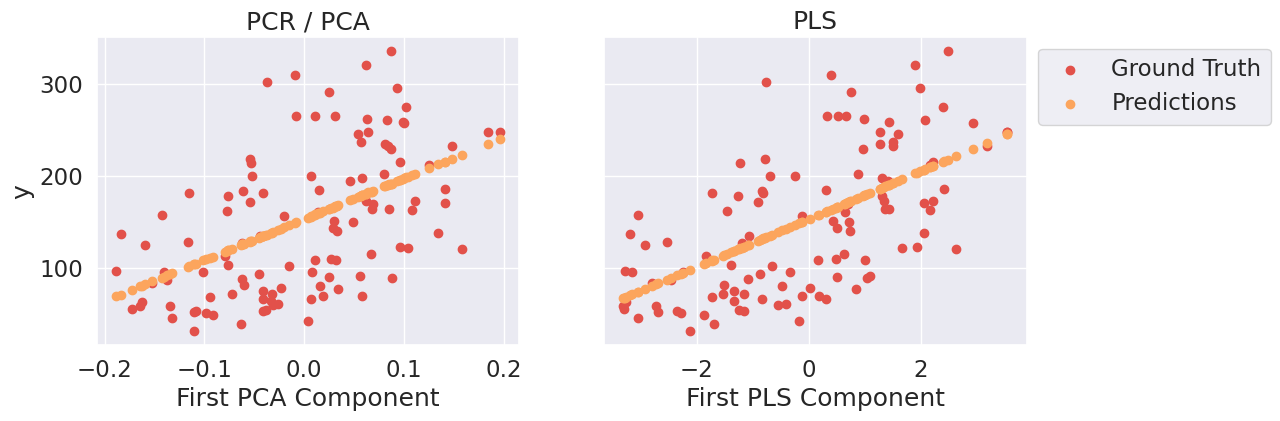

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].scatter(pca.transform(X_test), y_test, label="Ground Truth")
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), label="Predictions")
axes[0].set(xlabel="First PCA Component", ylabel="y", title="PCR / PCA")
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, label="Ground Truth")
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), label="Predictions")
axes[1].set(xlabel="First PLS Component", title="PLS")
axes[1].legend(bbox_to_anchor=(1, 1))
axes[0].get_legend().remove()
plt.show()


In [24]:
# Print metrics
print(f"PCR r-squared {pcr.score(X_test, y_test)}")
print(f"PLS r-squared {pls.score(X_test, y_test)}")


PCR r-squared 0.2762036659724231
PLS r-squared 0.3743020401490166
